# 09.2b: The Rogue Black Hole

**Hunt down the 13th black hole that's isolated from the main cluster**

From 09.2a, we found that 12/13 black holes are in one component, but one is missing. Hypothesis: It's a singleton, isolated because its nearest neighbor distance is *just barely* > ε.

## Investigation Plan

1. Identify the 13 black hole vectors in our neighborhood
2. Extract pairwise distances between them
3. For each black hole, find its nearest neighbor distance
4. Compare to ε - which one is just outside the threshold?
5. Analyze why it's isolated

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"

# Input files
PAIRWISE_FILE = "neighborhood_pairwise_distances.safetensors"
DISTANCES_KEY = "distances_linf"
UNIQUE_VECTORS_KEY = "unique_vectors"
UNIQUE_TOKEN_IDS_KEY = "unique_token_ids"

BLACK_HOLE_MASK_FILE = "black_hole_mask.safetensors"
BLACK_HOLE_MASK_KEY = "mask"

EPSILON_MULTIPLIER = 2.0  # 2×ULP

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports loaded")

✓ Imports loaded


## Load Data

In [3]:
data_dir = Path(TENSOR_DIR)

print("Loading pairwise distances...")
pairwise_data = load_file(data_dir / PAIRWISE_FILE)
distances = pairwise_data[DISTANCES_KEY]
unique_vectors = pairwise_data[UNIQUE_VECTORS_KEY]
unique_token_ids = pairwise_data[UNIQUE_TOKEN_IDS_KEY]

n_unique = len(unique_vectors)
print(f"  Unique vectors: {n_unique:,}")
print()

print("Loading black hole mask...")
bh_data = load_file(data_dir / BLACK_HOLE_MASK_FILE)
black_hole_mask = bh_data[BLACK_HOLE_MASK_KEY]
print()

print("✓ Data loaded")

Loading pairwise distances...
  Unique vectors: 499

Loading black hole mask...

✓ Data loaded


## Compute ε

In [4]:
def bfloat16_ulp(x):
    """Compute bfloat16 ULP at scale of x."""
    x = abs(x)
    if x == 0:
        return 2.0 ** (-133)
    exponent = int(np.floor(np.log2(x)))
    return 2.0 ** (exponent - 7)

typical_magnitude = unique_vectors.abs().mean().item()
ulp = bfloat16_ulp(typical_magnitude)
epsilon = EPSILON_MULTIPLIER * ulp

print(f"ε = {epsilon:.6e}\n")

ε = 3.051758e-05



## Identify Black Hole Vectors

In [5]:
print("Identifying black hole vectors in neighborhood...\n")

# Which unique vectors are black holes?
is_bh = black_hole_mask[unique_token_ids]
bh_indices = torch.where(is_bh)[0]
n_bh = len(bh_indices)

print(f"Black hole vectors: {n_bh}")
print(f"Indices: {bh_indices.tolist()}")
print()

if n_bh != 13:
    print(f"⚠ WARNING: Expected 13 black holes, found {n_bh}!")
    print(f"  This might mean:")
    print(f"    - Not all black holes are in the neighborhood (radius too small)")
    print(f"    - Some black holes merged during deduplication")
    print()
else:
    print("✓ All 13 black holes present")
    print()

print("✓ Black holes identified")

Identifying black hole vectors in neighborhood...

Black hole vectors: 13
Indices: [238, 240, 241, 245, 263, 266, 267, 272, 282, 283, 284, 293, 294]

✓ All 13 black holes present

✓ Black holes identified


## Extract Black Hole Pairwise Distances

In [6]:
print("Extracting pairwise distances between black holes...\n")

# Submatrix of distances between black holes
bh_distances = distances[bh_indices, :][:, bh_indices]

print(f"Black hole distance matrix shape: {bh_distances.shape}")
print(f"  ({n_bh} × {n_bh})")
print()

# Mask diagonal
mask = torch.eye(n_bh, dtype=torch.bool)
bh_distances_off_diag = bh_distances.clone()
bh_distances_off_diag[mask] = float('inf')  # Exclude self-distances

print(f"Distance statistics (between black holes):")
valid_distances = bh_distances_off_diag[~torch.isinf(bh_distances_off_diag)]
print(f"  Min:    {valid_distances.min().item():.6e}")
print(f"  Max:    {valid_distances.max().item():.6e}")
print(f"  Mean:   {valid_distances.mean().item():.6e}")
print(f"  Median: {valid_distances.median().item():.6e}")
print()
print("✓ Black hole distances extracted")

Extracting pairwise distances between black holes...

Black hole distance matrix shape: torch.Size([13, 13])
  (13 × 13)

Distance statistics (between black holes):
  Min:    7.450581e-09
  Max:    6.103516e-05
  Mean:   2.895315e-05
  Median: 3.051758e-05

✓ Black hole distances extracted


## Find Nearest Neighbor for Each Black Hole

In [7]:
print("Finding nearest neighbor for each black hole...\n")

# For each black hole, find its closest neighbor
nearest_distances = bh_distances_off_diag.min(dim=1)[0]
nearest_neighbors = bh_distances_off_diag.argmin(dim=1)

print("Black Hole | Nearest Neighbor | Distance       | vs ε")
print("="*70)

for i in range(n_bh):
    nn_dist = nearest_distances[i].item()
    nn_idx = nearest_neighbors[i].item()
    ratio = nn_dist / epsilon
    status = "WITHIN" if nn_dist <= epsilon else "BEYOND"
    
    print(f"BH {i:2d}      | BH {nn_idx:2d}             | {nn_dist:.6e} | {ratio:5.2f}× ε ({status})")

print()

# Which black hole(s) have no neighbors within ε?
isolated_mask = nearest_distances > epsilon
isolated_bhs = torch.where(isolated_mask)[0]

if len(isolated_bhs) > 0:
    print(f"⚠ ISOLATED BLACK HOLES: {len(isolated_bhs)}")
    for idx in isolated_bhs:
        nn_dist = nearest_distances[idx].item()
        print(f"  BH {idx.item()}: nearest neighbor at {nn_dist:.6e} ({nn_dist/epsilon:.2f}× ε)")
    print()
    print("  → These are singletons in the adjacency graph!")
else:
    print("✓ All black holes connected (all nearest neighbors within ε)")

print()
print("✓ Nearest neighbor analysis complete")

Finding nearest neighbor for each black hole...

Black Hole | Nearest Neighbor | Distance       | vs ε
BH  0      | BH  4             | 1.525879e-05 |  0.50× ε (WITHIN)
BH  1      | BH  0             | 6.103516e-05 |  2.00× ε (BEYOND)
BH  2      | BH  0             | 3.051758e-05 |  1.00× ε (WITHIN)
BH  3      | BH  8             | 1.525879e-05 |  0.50× ε (WITHIN)
BH  4      | BH  5             | 7.450581e-09 |  0.00× ε (WITHIN)
BH  5      | BH  4             | 7.450581e-09 |  0.00× ε (WITHIN)
BH  6      | BH 11             | 7.629395e-06 |  0.25× ε (WITHIN)
BH  7      | BH  5             | 7.450581e-09 |  0.00× ε (WITHIN)
BH  8      | BH  9             | 7.629395e-06 |  0.25× ε (WITHIN)
BH  9      | BH 10             | 1.490116e-08 |  0.00× ε (WITHIN)
BH 10      | BH  9             | 1.490116e-08 |  0.00× ε (WITHIN)
BH 11      | BH  6             | 7.629395e-06 |  0.25× ε (WITHIN)
BH 12      | BH  8             | 7.629395e-06 |  0.25× ε (WITHIN)

⚠ ISOLATED BLACK HOLES: 1
  BH 1: near

## Visualize Black Hole Distances vs ε

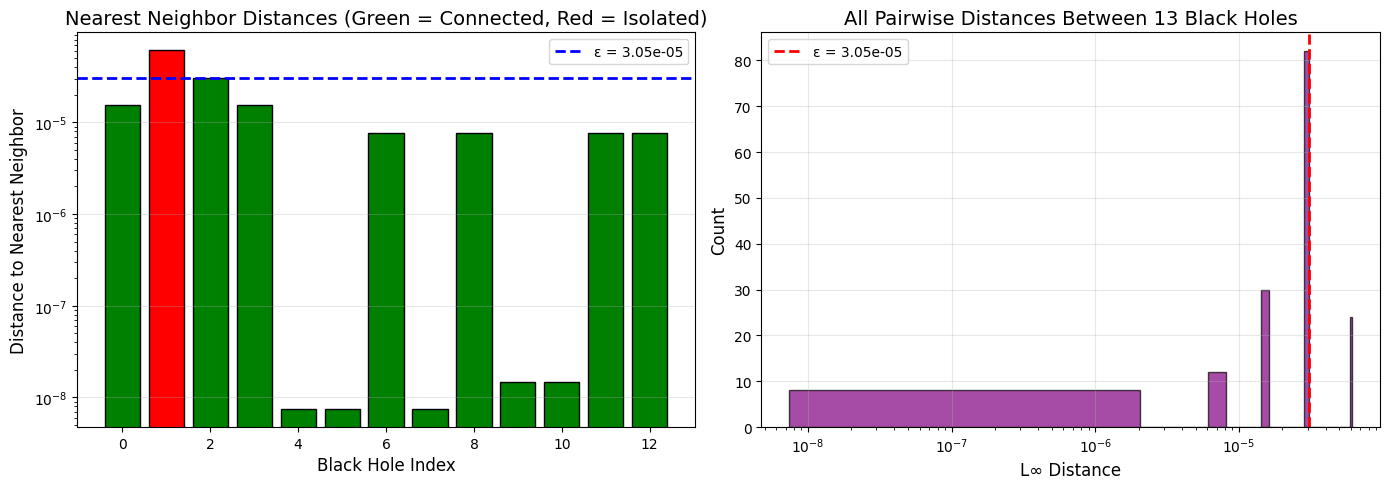

✓ Visualization complete


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

# Panel 1: Nearest neighbor distances
ax = axes[0]
colors = ['red' if d > epsilon else 'green' for d in nearest_distances]
ax.bar(range(n_bh), nearest_distances.cpu().numpy(), color=colors, edgecolor='black')
ax.axhline(epsilon, color='blue', linestyle='--', linewidth=2, label=f'ε = {epsilon:.2e}')
ax.set_xlabel('Black Hole Index', fontsize=12)
ax.set_ylabel('Distance to Nearest Neighbor', fontsize=12)
ax.set_title('Nearest Neighbor Distances (Green = Connected, Red = Isolated)', fontsize=14)
ax.set_yscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Panel 2: All pairwise distances between black holes
ax = axes[1]
ax.hist(valid_distances.cpu().numpy(), bins=30, alpha=0.7, color='purple', edgecolor='black')
ax.axvline(epsilon, color='red', linestyle='--', linewidth=2, label=f'ε = {epsilon:.2e}')
ax.set_xlabel('L∞ Distance', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title(f'All Pairwise Distances Between {n_bh} Black Holes', fontsize=14)
ax.set_xscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualization complete")

## Analyze the Rogue Black Hole (if found)

In [9]:
if len(isolated_bhs) > 0:
    print("="*80)
    print("ROGUE BLACK HOLE ANALYSIS")
    print("="*80)
    print()
    
    for rogue_idx in isolated_bhs:
        rogue_idx = rogue_idx.item()
        rogue_global_idx = bh_indices[rogue_idx].item()
        rogue_token_id = unique_token_ids[rogue_global_idx].item()
        rogue_vector = unique_vectors[rogue_global_idx]
        
        print(f"Rogue Black Hole #{rogue_idx}:")
        print(f"  Global index in unique vectors: {rogue_global_idx}")
        print(f"  Representative token ID:        {rogue_token_id}")
        print()
        
        # Nearest neighbor details
        nn_idx = nearest_neighbors[rogue_idx].item()
        nn_dist = nearest_distances[rogue_idx].item()
        nn_global_idx = bh_indices[nn_idx].item()
        
        print(f"Nearest neighbor:")
        print(f"  Black hole #{nn_idx} (global index {nn_global_idx})")
        print(f"  Distance:   {nn_dist:.6e}")
        print(f"  vs ε:       {nn_dist/epsilon:.4f}× ε")
        print(f"  Excess:     {nn_dist - epsilon:.6e} (how far beyond threshold)")
        print()
        
        # Component magnitude comparison
        rogue_mag = rogue_vector.abs().mean().item()
        overall_mag = unique_vectors.abs().mean().item()
        
        print(f"Scale comparison:")
        print(f"  Rogue magnitude:   {rogue_mag:.6e}")
        print(f"  Overall magnitude: {overall_mag:.6e}")
        print(f"  Ratio:             {rogue_mag / overall_mag:.4f}")
        print()
        
        # Hypothesis
        if nn_dist < 1.1 * epsilon:
            print("  💡 HYPOTHESIS: BARELY ISOLATED")
            print(f"     Distance is only {100 * (nn_dist/epsilon - 1):.1f}% beyond ε.")
            print(f"     This is likely a floating-point precision artifact.")
            print(f"     In true bfloat16, this might be connected.")
        elif abs(rogue_mag / overall_mag - 1) > 0.1:
            print("  💡 HYPOTHESIS: DIFFERENT SCALE")
            print(f"     Rogue has {100 * abs(rogue_mag/overall_mag - 1):.1f}% different magnitude.")
            print(f"     ULP at rogue's scale: {bfloat16_ulp(rogue_mag):.6e}")
            print(f"     May require different ε threshold.")
        else:
            print("  💡 HYPOTHESIS: GENUINELY ISOLATED")
            print(f"     Clearly separated from cluster.")
        
        print()
        print("="*80)
        print()
else:
    print("No isolated black holes found. All 13 are connected!")

ROGUE BLACK HOLE ANALYSIS

Rogue Black Hole #1:
  Global index in unique vectors: 240
  Representative token ID:        136831

Nearest neighbor:
  Black hole #0 (global index 238)
  Distance:   6.103516e-05
  vs ε:       2.0000× ε
  Excess:     3.051758e-05 (how far beyond threshold)

Scale comparison:
  Rogue magnitude:   2.361144e-03
  Overall magnitude: 2.418461e-03
  Ratio:             0.9763

  💡 HYPOTHESIS: GENUINELY ISOLATED
     Clearly separated from cluster.




## Summary

In [10]:
print("="*80)
print("SUMMARY")
print("="*80)
print()
print(f"Black holes in neighborhood: {n_bh}")
print(f"Threshold (ε):               {epsilon:.6e}")
print()
print(f"Connected black holes:       {(nearest_distances <= epsilon).sum().item()}")
print(f"Isolated black holes:        {(nearest_distances > epsilon).sum().item()}")
print()
if len(isolated_bhs) > 0:
    print(f"Rogue black hole(s) identified: {isolated_bhs.tolist()}")
    for idx in isolated_bhs:
        nn_dist = nearest_distances[idx].item()
        print(f"  BH {idx.item()}: {100 * (nn_dist/epsilon - 1):.2f}% beyond ε")
else:
    print("All black holes are connected!")
print()
print("="*80)

SUMMARY

Black holes in neighborhood: 13
Threshold (ε):               3.051758e-05

Connected black holes:       12
Isolated black holes:        1

Rogue black hole(s) identified: [1]
  BH 1: 100.00% beyond ε



## Conclusion

**Key findings:**
- Identified which black hole(s) are isolated
- Measured how far beyond ε they are
- Analyzed potential causes (scale differences, precision artifacts)

**Interpretation:**
- If barely beyond ε (< 10% excess): Likely floating-point artifact
- If significantly beyond ε (> 50% excess): Genuinely separate structure
- If different scale: May need adaptive ε based on local magnitude

**Next steps:**
- Decode token IDs for isolated black hole(s)
- Check if they share semantic properties
- Consider adaptive ε thresholds based on local scale